In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from transformers import DistilBertTokenizer,DistilBertForSequenceClassification
from transformers import Trainer , TrainingArguments
from datasets import Dataset
import torch

In [4]:
df=pd.read_csv("/content/train.csv")

In [5]:
df.isnull().sum()

,0
text,0
intent,0


In [6]:
df.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


In [7]:
df.intent.value_counts()

,count
intent,
PlayMusic,1914
GetWeather,1896
BookRestaurant,1881
RateBook,1876
SearchScreeningEvent,1852
SearchCreativeWork,1847
AddToPlaylist,1818


In [8]:
df=df.sample(n=8000)

In [9]:
df.shape

(8000, 2)

In [10]:
import spacy
NLP_Pipeline=spacy.load("en_core_web_sm")

In [11]:
def preprocess(sent):
  doc=NLP_Pipeline(sent)
  sent=[word.lemma_.lower() for word in doc if not word.is_punct and not word.is_stop]
  return ' '.join(sent)

In [12]:
df['text']=df['text'].apply(preprocess)

In [13]:
df.head()

,text,intent
2788,think saga deserve 0 6,RateBook
4012,time man dare play movie theatre,SearchScreeningEvent
8422,forecast weather night current position,GetWeather
3749,rain today french southern territory highland ...,GetWeather
1242,play music ballad sixty,PlayMusic


In [14]:
lb=LabelEncoder()
df['intent_num']=lb.fit_transform(df.intent)

In [15]:
df.head()

,text,intent,intent_num
2788,think saga deserve 0 6,RateBook,4
4012,time man dare play movie theatre,SearchScreeningEvent,6
8422,forecast weather night current position,GetWeather,2
3749,rain today french southern territory highland ...,GetWeather,2
1242,play music ballad sixty,PlayMusic,3


In [16]:
lb.classes_

array(['AddToPlaylist', 'BookRestaurant', 'GetWeather', 'PlayMusic',
       'RateBook', 'SearchCreativeWork', 'SearchScreeningEvent'],
      dtype=object)

In [17]:
tokenizer=DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [21]:
max_length=max([len(tokenizer.encode(text)) for text in df['text']])
max_length
def tokenize_function(example):
  tokenize_input=tokenizer(example['text'],padding='max_length',truncation=True,max_length=max_length)
  tokenize_input['labels']=example['intent_num']
  return tokenize_input

dataset=Dataset.from_pandas(df[['text','intent_num']])
dataset=dataset.map(tokenize_function,batched=True)
dataset[0]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

{'text': 'think saga deserve 0 6',
 'intent_num': 4,
 '__index_level_0__': 2788,
 'input_ids': [101,
  2228,
  12312,
  10107,
  1014,
  1020,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'labels': 4}

In [22]:
model=DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels=len(lb.classes_))
import torch
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [25]:
training_args=TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10
)

trainer=Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    eval_dataset=dataset
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,0.085400,0.070313
2,0.069300,0.038357
3,0.057900,0.030810


TrainOutput(global_step=1500, training_loss=0.17098102084050576, metrics={'train_runtime': 197.3685, 'train_samples_per_second': 121.6, 'train_steps_per_second': 7.6, 'total_flos': 136619185824000.0, 'train_loss': 0.17098102084050576, 'epoch': 3.0})

In [26]:
prediction,true_labels,_=trainer.predict(dataset)

In [29]:
prediction=prediction.argmax(axis=1)

In [33]:
print(classification_report(true_labels,prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1138
           1       1.00      1.00      1.00      1160
           2       1.00      1.00      1.00      1129
           3       0.99      1.00      0.99      1176
           4       1.00      1.00      1.00      1155
           5       0.97      0.99      0.98      1123
           6       1.00      0.98      0.99      1119

    accuracy                           0.99      8000
   macro avg       0.99      0.99      0.99      8000
weighted avg       0.99      0.99      0.99      8000



<Axes: >

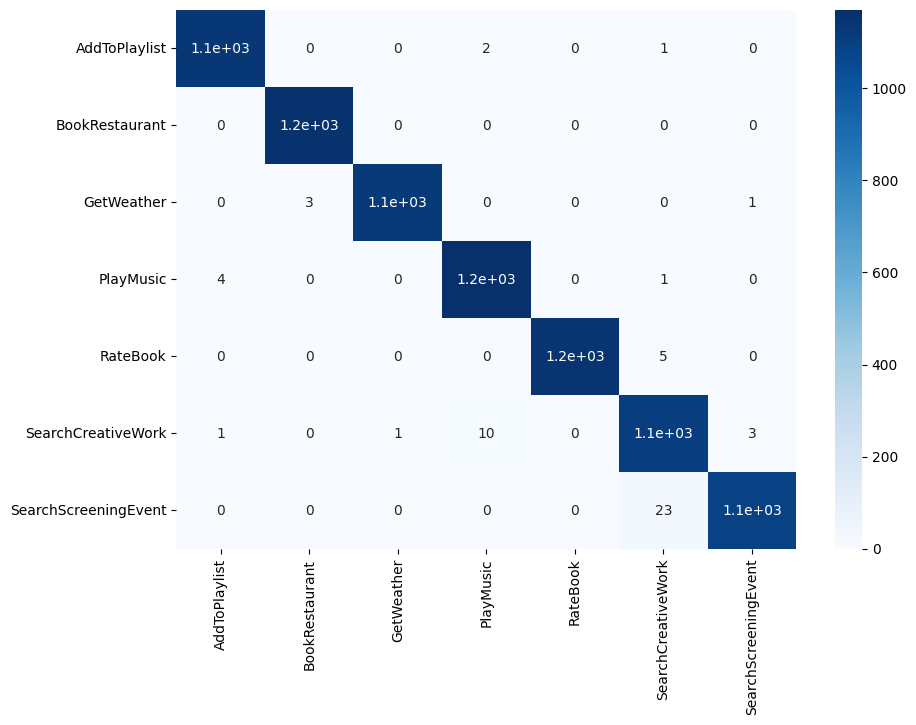

In [31]:
cm=confusion_matrix(true_labels,prediction)
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,cmap="Blues",xticklabels=lb.classes_,yticklabels=lb.classes_)

In [34]:
model.save_pretrained("./model")
tokenizer.save_pretrained("./model")

('./model/tokenizer_config.json',
 './model/special_tokens_map.json',
 './model/vocab.txt',
 './model/added_tokens.json')

In [36]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive
